# Simulate JEMRIS Phantom with MRZero
(C) 2025 Forschungszentrum Jülich

Author: Jörg Felder

In [1]:
import os
import h5py
import torch

import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import matplotlib.pyplot as plt

In [2]:
torch.set_num_threads(1)
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
torch.set_num_workers=0

In [3]:
filepath = '/workspaces/juart'

## 1. Load H5 Sample File and create MRZero sampe from it

In [4]:
# Read JEMRIS sample file
filename = 'SheppLogan.h5'

fullfilename = os.path.join(filepath, filename)

# open h5 file for reading 
f = h5py.File(fullfilename, "r")

# Get the HDF5 group 'sample'
group = f['sample']

# read group data
data = group['data'][()]
offset = group['offset'][()]
resolution = group['resolution'][()]

# close file
f.close()

In [5]:
# converst JEMRIS sample data into torch tensors
T1 = np.divide( 1, data[:,:,1], out=np.zeros_like(data[:,:,1], dtype=float), where=data[:,:,1]!=0)
T2 = np.divide( 1, data[:,:,2], out=np.zeros_like(data[:,:,2], dtype=float), where=data[:,:,2]!=0)

PD = torch.tensor( np.transpose(data[:,:,0]) )
T1 = torch.tensor( np.transpose(T1 / 1e3) )      # conversion from ms to s required
T2 = torch.tensor( np.transpose(T2 / 1e3) )      # conversion from ms to s required
DB = torch.tensor( np.transpose(data[:,:,4]) )

In [6]:
# add axis
PD = PD[:,:,None]
T1 = T1[:,:,None]
T2 = T2[:,:,None]
DB = DB[:,:,None]

In [7]:
# create missing entries
T2dash = torch.ones_like(PD) * 0.03     # don't know why this needs to be different from zero
D = torch.zeros_like(PD)
B1 = torch.zeros_like(PD)
B1[PD!=0] = 1.0
B1 = B1[None, :, :, :]                  # needs first axis to be number of coil elements
coil_sens = torch.ones_like(B1)


In [8]:
# create the phantom
size = torch.tensor( (resolution[0,0]*PD.shape[0]/1000, resolution[1,0]*PD.shape[1]/1000,  resolution[2,0]/1000)  )
phantom = mr0.VoxelGridPhantom(PD=PD, T1=T1, T2=T2, T2dash=T2dash, D=D, B0=DB, B1=B1, coil_sens=coil_sens,size=size)

VoxelGridPhantom
size = tensor([0.1000, 0.1000, 0.0010])


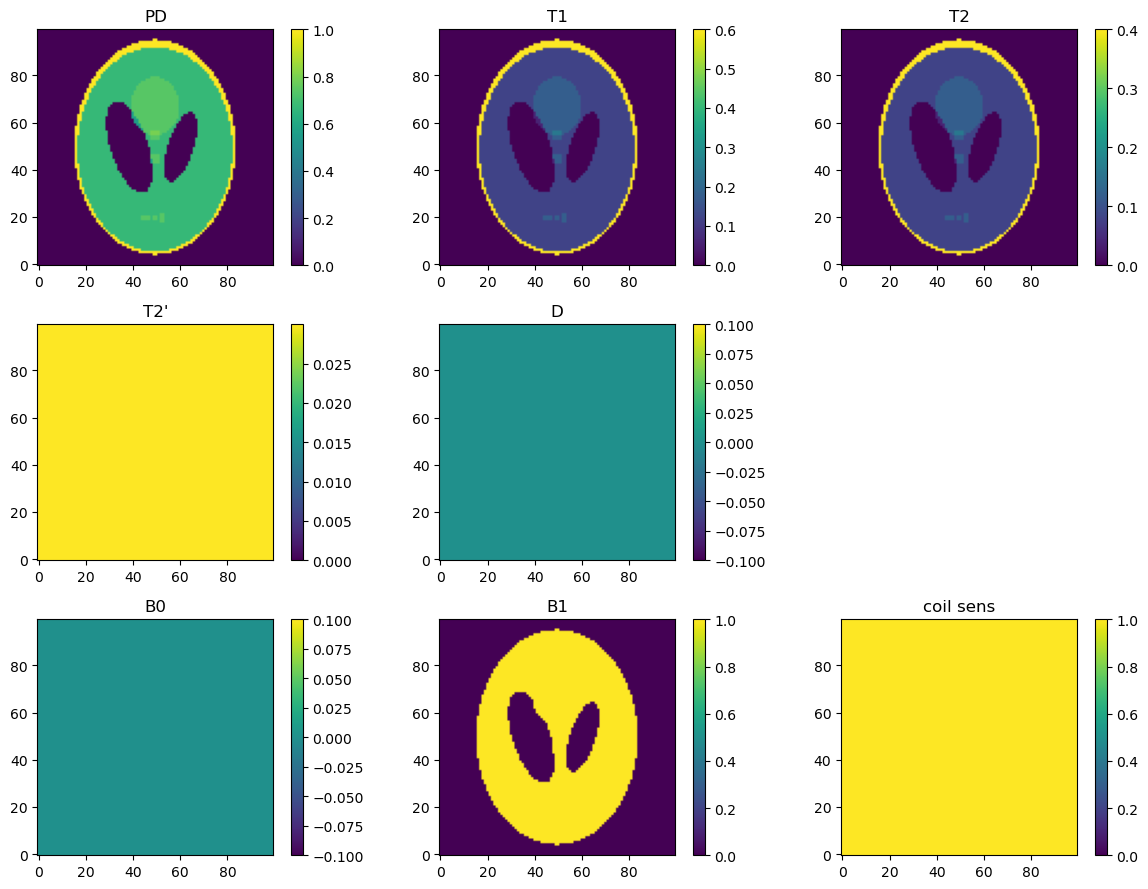

In [9]:
phantom.plot()

In [10]:
data = phantom.build()

## 2. Simmulate standard GRE sequence for Testing

In [11]:
# Select sequence file
seq_filename = os.path.join(filepath, 'gre_noDI.seq')

seq0 = mr0.Sequence.import_file(seq_filename)

# Very precise simulation
# graph = mr0.compute_graph(seq0, data, 10000, 1e-7)
# signal = mr0.execute_graph(graph, seq0, data, 1e-7, 1e-7)

# Average precision
graph = mr0.compute_graph(seq0, data, 10000, 1e-4)
signal = mr0.execute_graph(graph, seq0, data, 1e-3, 1e-4)

>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.000716291 s
Compute Graph
Computing Graph: 0.000707375 s
Analyze Graph
Analyzing Graph: 0.0000105 s
Converting Rust -> Python: 0.000228625 s
<<<< Rust <<<<
Calculating repetition 64 / 64 - done


### Reconstruct image

In [12]:
seq = pp.Sequence()
seq.read(seq_filename)

permvec = seq.evaluate_labels(evolution='adc')['LIN']
Nphase = len(permvec)
Nread = int(seq.adc_library.data[1][0])

kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
ipermvec = np.argsort(permvec)
kspace=kspace[:,ipermvec]

In [13]:
# fftshift FFT fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

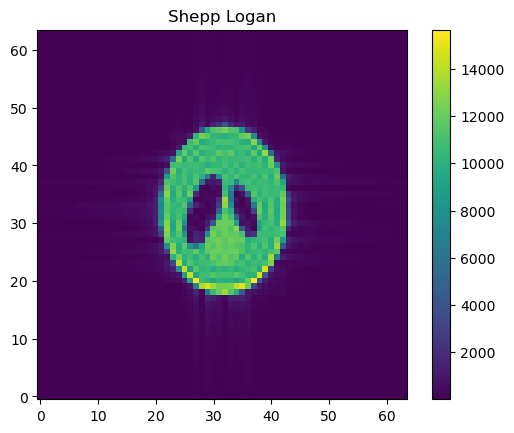

In [14]:
plt.title('Shepp Logan')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()

## 3. Create QRAGE sequence and simulate

In [15]:
import sys
import platform
from types import SimpleNamespace

In [16]:
from qrage.sequence.qrage import QRAGE

### Create Sequence

In [17]:
seq_write = True
seq_debug = False
seq_plot = True
seq_calculate_gradient_spectrum = True
seq_check_timing = False
seq_test_report = False
seq_filename = os.path.join (filepath, 'qrage.seq')

In [18]:
seq = pp.Sequence()

system = pp.Opts(
    max_grad=28,
    grad_unit="mT/m",
    max_slew=200,
    slew_unit="T/m/s",
    rf_ringdown_time=40e-6,
    rf_dead_time=100e-6,
    # adc_dead_time=0,
    adc_dead_time=10e-6,
)

if seq_debug:
    num_spokes = 2
    num_sets = 19
    num_echoes = 9
    num_partitions_per_block = 16
    num_autocalibration_lines = 0
    acceleration_factor = 1
    fov = np.array([256, 256, 16]) * 1e-3
    matrix_size = np.array([256, 256, 16])
    readout_bandwidth = 390.625
else:
    num_spokes = 8
    num_sets = 19
    num_echoes = 9
    num_partitions_per_block = 16
    num_autocalibration_lines = 32
    acceleration_factor = 1
    fov = np.array([256, 256, 16]) * 1e-3
    matrix_size = np.array([256, 256, 16])
    readout_bandwidth = 390.625

axes = SimpleNamespace()

xyz = ["x", "y", "z"]

axes.d1 = "x"  # Readout dimension
axes.d2 = "y"  # Inner phase-encoding loop
axes.d3 = "z"  # Outer phase-enconding loop

axes.n1 = xyz.index(axes.d1)
axes.n2 = xyz.index(axes.d2)
axes.n3 = xyz.index(axes.d3)

In [19]:
seq.set_definition("FOV", fov.tolist())
seq.set_definition("RES", matrix_size.tolist())
seq.set_definition("Name", "QRAGE")

In [20]:
qrage = QRAGE(
    fov,
    matrix_size,
    axes,
    readout_bandwidth,
    num_spokes,
    num_sets,
    num_echoes,
    num_partitions_per_block,
    num_autocalibration_lines,
    acceleration_factor,
    adiabatic_pulse_type="hypsec_n",
    adiabatic_pulse_overdrive=2.0,
    debug=False,
    system=system,
)

/workspaces/juart/src/qrage/sequence/inversion.py:63: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  self.rf180 = make_adiabatic_pulse(
/workspaces/juart/src/qrage/sequence/readout.py:95: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  pp.make_sinc_pulse(
/workspaces/juart/src/qrage/sequence/readout.py:130: UserWarning: Specified ADC delay 0.00 us is less than the dead time 10 us. Delay was increased to the dead time.
  self.adc = pp.make_adc(


In [21]:
qrage.run(seq)

In [22]:
qrage.get_timing(seq)
print(
    "TR %s ms" % np.round(qrage.TR, decimals=1),
    "dTI %s ms" % np.round(qrage.dTI, decimals=1),
    "TI0 %s ms" % np.round(qrage.TI0, decimals=1),
    "dTE %s ms" % np.round(qrage.dTE, decimals=1),
    "TE0 %s ms" % np.round(qrage.TE0, decimals=1),
)

TR 9089.8 ms dTI 477.6 ms TI0 235.1 ms dTE 2.8 ms TE0 3.2 ms


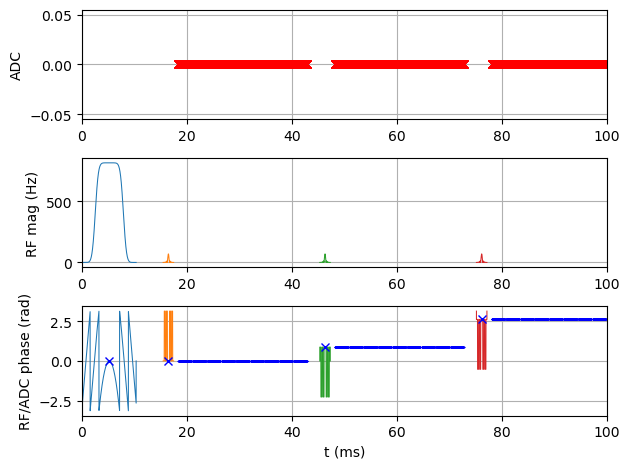

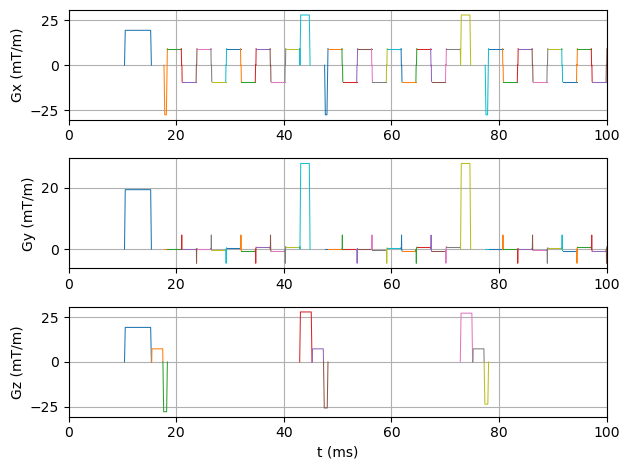

In [23]:
if seq_plot:
    seq.plot(time_range=[0, 0.1], grad_disp="mT/m", time_disp="ms", show_blocks=False)

Resonance frequencies of gradients (x, y, z) are:  [186.66666667 186.66666667  66.66666667]


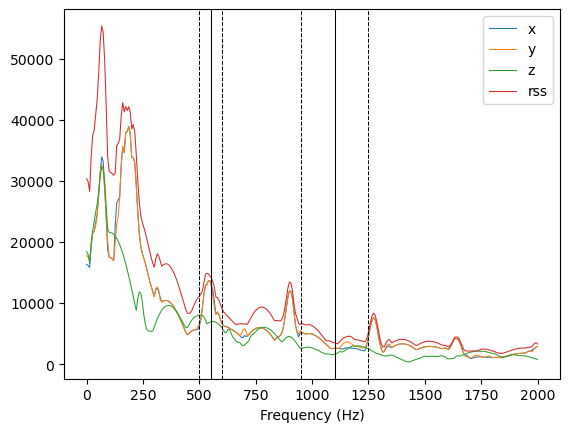

In [24]:
if seq_calculate_gradient_spectrum:
    spects, spects_sos, freq, _ = seq.calculate_gradient_spectrum( 
        acoustic_resonances=[{'frequency': 1100, 'bandwidth': 300}, {'frequency': 550, 'bandwidth': 100}])
    res_freqs = freq[np.argmax(spects, axis=1)]
    print("Resonance frequencies of gradients (x, y, z) are: ", res_freqs)

In [25]:
if seq_check_timing:
    ok, error_report = seq.check_timing()
    if ok:
        print("Timing check passed")
    else:
        print("Timing check failed")
        [print(e) for e in error_report]

In [26]:
if seq_test_report:
    rep = seq.test_report()
    print(rep)

In [27]:
if seq_write:
    seq.write(seq_filename)

### Simualte

In [28]:
# seq0 = mr0.Sequence.import_file(seq_filename)

# # Very precise simulation
# # graph = mr0.compute_graph(seq0, data, 10000, 1e-7)
# # signal = mr0.execute_graph(graph, seq0, data, 1e-7, 1e-7)

# # Average precision
# graph = mr0.compute_graph(seq0, data, 10000, 1e-4)
# signal = mr0.execute_graph(graph, seq0, data, 1e-3, 1e-4)

In [29]:
# # Read sequence with pypulseq to get information on acquisition scheme
# seq = pp.Sequence()
# seq.read(seq_filename)

### Convert into ISMRMRD format (without full header)

In [30]:
# # Tool from Felix Landmeyer to create ISMRMRD dataset from MRZERO simulation
# import seqtraj_to_mrd

In [31]:
# # Set required definitions
# NCol = matrix_size[1]
# seq.set_definition('MaxAdcSegmentLength',NCol)

In [32]:
# # save file
# seqtraj_to_mrd.mr0_to_mrd(seq, signal, os.path.join(filepath,'LocalData', 'Simulations', 'qrage.h5'))

## 4. Preprocessing of QRAGE data

In [33]:
from juart.preproc.data import KSpaceData
from juart.preproc.trajectory import KSpaceTrajectory

In [34]:
import ismrmrd

In [35]:
# load ISMRMRD File
full_h5_ismrmrd_fname = os.path.join(filepath,'LocalData', 'Simulations', 'qrage.h5')
dataset = ismrmrd.Dataset(
    full_h5_ismrmrd_fname,
    dataset_name="dataset",
    create_if_needed=False,
)

In [36]:
NCha = 1
NCol = matrix_size[1]
NLin = num_spokes
NPar = matrix_size[2]
NSli = 1
NSet = num_sets
NEco = num_echoes

NPar_post, NSli_post = NSli, NPar
NCha_comp, ISet_comp, IEco_comp = NCha, slice(NSet - 1, NSet), slice(0, 1)
NImx, NImy, ISet_coil, IEco_coil = 256, 256, slice(15, 19), slice(0, 1)

NAcl = num_autocalibration_lines
NUsf = acceleration_factor
NLin_retro = NLin

In [37]:
print(NCha, NCol, NLin, NPar, NSli, NSet, NEco)

1 256 8 16 1 19 9


In [38]:
# load kspace
kdata = KSpaceData((NCha, NCol, NLin, NPar, NSli, NSet, NEco))
kdata.read_data(dataset, is_pulseq=True)

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=28976) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


  0%|          | 0/21888 [00:00<?, ?it/s]

In [39]:
# Undersample along line dimension
kdata.index_data([slice(None), slice(None), slice(NLin_retro), ...])

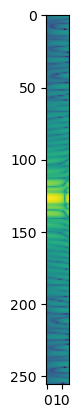

In [40]:
# plot undersampled kspace
plt.figure()
plt.imshow(torch.log(torch.abs(kdata.kdata[0, :, 0, :, 0, 0, 0]) + 1e-16).numpy())

In [41]:
kdata.apply_mask(NUsf, NAcl, is_pulseq=True)
kdata.reconstruct_partitions()

  0%|          | 0/1368 [00:00<?, ?it/s]

In [42]:
# Swap Par and Sli Partition
kdata.swapaxes(3, 4)

In [43]:
# compress kspace
comp_matrix = kdata.compression_matrix(NCha_comp, ISet_comp, IEco_comp)
kdata.compress_data(comp_matrix)

  0%|          | 0/1368 [00:00<?, ?it/s]

In [44]:
# Swap Col and Lin dimension
kdata.swapaxes(1, 2)

In [45]:
# get new shape
NCha, NLin, NCol, NPar, NSli, NSet, NEco = kdata.kdata_shape

(-0.5, 255.5, 15.5, -0.5)

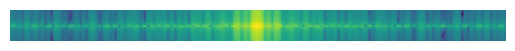

In [46]:
plt.imshow(
    torch.log(torch.abs(kdata.kdata[0, 0, :, 0, :, 0, 0].T)).numpy())
plt.axis("off")

In [47]:
# write preprocessed data
full_h5_preproc_fname = os.path.join(filepath, 'LocalData', 'Simulations','qrage_grappa_pytorch.h5')

with h5py.File(full_h5_preproc_fname, "w", libver="latest") as out_file:
    out_file.create_dataset(
        "d", data=kdata.kdata.numpy(), chunks=(NCha, NLin, NCol, 1, 1, 1, 1)
    )

### Store the trajectory

In [48]:
ktraj = KSpaceTrajectory(NLin, NCol, NSet, NEco)

In [49]:
with h5py.File(full_h5_preproc_fname, "r+", libver="latest") as h5_preproc_file:
    dset = h5_preproc_file.create_dataset(
        "k", data=ktraj.ktraj_nom.numpy(), chunks=(2, NLin_retro, NCol, 1, 1, 1, 1)
    )

### Coil sensitivity estimation

In [52]:
sensmaps = kdata.get_sensmaps(ktraj.ktraj_nom, (NCha, NImx, NImy, 1, NSli, 1, 1))

  0%|          | 0/16 [00:00<?, ?it/s]

TypeError: TransferFunctionOperator.__init__() got an unexpected keyword argument 'nonuniform_axes'

In [ ]:
with h5py.File(full_h5_preproc_fname, "r+", libver="latest") as h5_preproc_file:
    dset = h5_preproc_file.create_dataset(
        "C",
        data=sensmaps.numpy(),
        chunks=(NCha_comp, NImx, NImy, NPar_post, NSli_post, 1, 1),
    )

In [ ]:
plt.figure()
plt.imshow(torch.abs(sensmaps[0, :, :, 0, 8, 0, 0]).numpy())
plt.colorbar()

### Convert to ZARR format and save

In [ ]:
import zarr

In [ ]:
# prepare storage
full_zarr_preproc_fname = os.path.join(filepath,'LocalData', 'Simulations', 'rage_grappa_pytorch.zarr')
store = zarr.storage.LocalStore(full_zarr_preproc_fname)
root = zarr.create_group(
    store=store,
    overwrite=True,
)

In [ ]:
# write data
with h5py.File(full_h5_preproc_fname, "r") as f:
    for key in f.keys():
        print(key)
        array = root.create_array(
            name=key,
            shape=f[key].shape,
            chunks=f[key].chunks,
            dtype=f[key].dtype,
            overwrite=True,
        )
        array[:] = f[key][:]

In [ ]:
# requires: pip install rich[tree]
root.tree()

In [ ]:
store.close()

## 5. Reconstruct

In [ ]:
from juart.conopt.functional.fourier import nonuniform_fourier_transform_adjoint
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.recon.mirage import MIRAGE
from juart.recon.monitoring import ConvergenceMonitor
from juart.vis import MultiPlotter

torch.set_num_threads(16)
torch.set_grad_enabled(False)

In [ ]:
# Open zarr storage
full_zarr_preproc_fname = os.path.join(filepath,'LocalData', 'Simulations', 'rage_grappa_pytorch.zarr')
store = zarr.storage.LocalStore(full_zarr_preproc_fname)

In [ ]:
nUS = 1
iS = 8

In [ ]:
zarr_preproc_file  = zarr.open_group(store, mode="r")

nC, nX, nY, nZ, nS = zarr_preproc_file["C"].shape[:5]
nC, spokes, baseresolution, nZ, nS, nTI, nTE = zarr_preproc_file["d"].shape

nTI, nTE = 1, 1

shape = (nX, nY, nZ, 1, nTI, nTE)

print("Reconstructing slice %s of %s." % (iS, nS))

nK = baseresolution * nUS

# Read data
C = zarr_preproc_file["C"][:, :, :, :, iS : iS + 1, :, :]
k = zarr_preproc_file["k"][:, :nUS, :, :, :, :nTI, :nTE]
d = zarr_preproc_file["d"][:, :nUS, :, :, iS : iS + 1, :nTI, :nTE] / 1e-4

k = k.reshape((2, nK, 1, nTI, nTE))
d = d.reshape((1, 1, 1, nK, 1, nTI, nTE))

C = torch.tensor(C, dtype=torch.complex64)
k = torch.tensor(k, dtype=torch.float32)
d = torch.tensor(d, dtype=torch.complex64)

In [ ]:
MultiPlotter(
    np.abs(C[..., 0, 0].numpy()),
    (1, 1),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [ ]:
MultiPlotter(
    torch.angle(C[..., 0, 0]).cpu().numpy(),
    (1, 1),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [ ]:
AHd = nonuniform_fourier_transform_adjoint(
    k, d, (nX, nY, nZ), (nC, nX, nY, nZ, 1, nTI, nTE)
)
AHd = torch.sum(torch.conj(C) * AHd, dim=0)

In [ ]:
H = nonuniform_transfer_function(
    k, (nX, nY, nZ, 1, nTI, nTE, nK), oversampling=(2, 2, 1)
)

In [ ]:
MultiPlotter(
    torch.abs(H[0, :, :, 0, 0, :, :]).cpu().numpy(),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="viridis",
    vmin=0,
    vmax=1,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [ ]:
MultiPlotter(
    torch.abs(AHd[..., 0, 0, :, :]).cpu().numpy(),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
    vmin=0,
    vmax=5,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [ ]:
MultiPlotter(
    torch.angle(AHd[..., 0, 0, :, :]).cpu().numpy(),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
    vmin=-np.pi,
    vmax=np.pi,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [ ]:
support = torch.abs(C).max(dim=0).values > 0

cm = ConvergenceMonitor(support + torch.zeros(shape), support, logfile=None)

solver = MIRAGE(
    C[..., 0, 0],
    AHd,
    H,
    (nX, nY, nZ, 1, nTI, nTE),
    lambda_wavelet=1e-3,
    lambda_hankel=None,
    lambda_casorati=None,
    weight_wavelet=0.5,
    weight_hankel=0.5,
    weight_casorati=0.5,
    inner_iter=5,
    outer_iter=50,
    callback=cm.callback,
)

In [ ]:
# Run MIRAGE reconstruction
solver.solve()

In [ ]:
z_image = solver.solver.results["v"].view(torch.complex64).reshape(shape)

In [ ]:
MultiPlotter(
    torch.abs(z_image[..., 0, 0, :, :]).cpu().numpy(),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
    vmin=0,
    vmax=2,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [ ]:
# create an array of k-space lines
# signal_line = torch.reshape((signal), (NCha, NCol,  NLin * NPar * NSli * NSet *NEco)).clone()

In [ ]:
# permvec_lin = seq.evaluate_labels(evolution='adc')['LIN']
# permvec_par = seq.evaluate_labels(evolution='adc')['PAR']
# permvec_set = seq.evaluate_labels(evolution='adc')['SET']
# permvec_eco = seq.evaluate_labels(evolution='adc')['ECO']

In [ ]:
# kspace = torch.zeros((NCha, NCol, NLin, NPar, NSli, NSet, NEco),dtype=signal.dtype)

In [ ]:
# for i in range(len(permvec_lin)): 
#     kspace[0,:,permvec_lin[i],permvec_par[i],0,permvec_set[i],permvec_eco[i]] = signal_line[0,:,i]

In [ ]:
# kdata = KSpaceData((NCha, NCol, NLin, NPar, NSli, NSet, NEco))

In [ ]:
# kdata.kdata = kspace